To Dos:
- Add sigma, phi and tau to optimization
  - How to draw from negative binomial with negative phi?
  - Tau as value to initialize y
  - why does sigma have a gradient of 0?
- Change loss function to negative log likelihood
- Toy Data
- Add prior knowledge to loss function
- Optimize for loops
- Check .clone() - Where do we need it and where is it redundant?



Haomann: Neg. Log Likelihood & Phi Variable
Anuar: Toy Data & Tau Variable
Timo: Sigma Variable

In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncexpon, truncnorm, nbinom
import pandas as pd
import torch
from torch import nn

In [2]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)
dtype = torch.float
device = torch.device("cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd /content/drive/MyDrive/CovidPrediction/

/content/drive/MyDrive/CovidPrediction


# Initialization

In [5]:
data = pd.read_csv('data/covid19model.csv')
data.head(3)

,date,hospit,serial_interval,delay_distr
0,2020-02-17,0,0.046535,0.013006
1,2020-02-18,0,0.087065,0.030046
2,2020-02-19,0,0.112061,0.044674


In [6]:
cero = torch.tensor(0, requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)

Initialize latent variables / parameters

In [7]:
tau = np.random.exponential(1 / 0.03)
#tau_t = torch.tensor(tau, requires_grad=True, device=device, dtype=dtype)
# b=(upper-lower)/scale, loc=lower, scale=scale
y = torch.tensor(truncexpon.rvs(b=(1000 - 0) / tau, loc=0, scale=tau), requires_grad=False, device=device, dtype=dtype)  # number of initial newly_infected (seed)

# For trunc ((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
#phi = torch.tensor(truncnorm.rvs((0 - 0) / 5, (np.inf - 0) / 5, loc=0, scale=5), requires_grad=True, device=device, dtype=dtype)  # dispersion (shape) parameter for observations
R0 = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True, device=device, dtype=dtype)  # initial reproduction number
alpha = torch.tensor(truncnorm.rvs((0 - 1/100) / 1/100, (5/100 - 1/100) / 1/100, loc=1/100, scale=1/100), requires_grad=True, device=device, dtype=dtype)  # probability to get hospitalized
sigma = torch.tensor(truncnorm.rvs((0 - 0.05) / 0.03, (0.15 - 0.05) / 0.03, loc=0.05, scale=0.03), requires_grad=True, device=device, dtype=dtype)  # standart deviation of random walk step

# Define Forward Pass

In [8]:
def forward_pass():

  # Initialize time series variables
  newly_infected = torch.zeros(num_observations)  # number of newly infected
  effectively_infectious = torch.zeros(num_observations)  # effective number of infectious individuals
  expected_daily_hospit = torch.zeros(num_observations)  # expected number of daily hospitalizations
  cumulative_infected = torch.zeros(num_observations)  # cumulative number of infected
  eta_t = torch.zeros(num_observations)  # transformed reproduction number
  epsilon_t = torch.zeros(num_observations)  # random walk
  St = torch.zeros(num_observations)  # fraction of susceptible population

  # seed initial infection / impute first num_impute days
  newly_infected[0:num_impute] = y.clone()
  cumulative_infected[0] = 0.
  cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
  St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in cumulative_infected[0:num_impute].clone()])

  # calculate Rt: the basic reproduction number
  beta_0 = torch.log(R0)
  epsilon_t[0] = torch.distributions.Normal(cero, sigma).rsample()
  for t in range(1, num_observations):
      epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].clone(), sigma).rsample()
  eta_t = beta_0 + epsilon_t  # + RNN[X_t, t]  # .clone() necessary?
  Rt = torch.exp(eta_t)

  # calculate infections
  for t in range(num_impute, num_observations):
      # Update cumulative newly_infected
      cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
      # effective number of infectous individuals
      for i in range(0, t - 1):
          effectively_infectious[t] += newly_infected[i].clone() * serial_interval[t - i].clone()
  # Adjusts for portion of pop that are susceptible
  St[num_impute:num_observations] = torch.maximum(population.clone() - cumulative_infected[num_impute:num_observations].clone(), cero) / population.clone() ## for loop necessary?

  # number of new infections (unobserved)
  newly_infected[num_impute:num_observations] = St[num_impute:num_observations].clone() * Rt[num_impute:num_observations].clone() * effectively_infectious[num_impute:num_observations].clone() # .clone() necessary?

  # calculate expected number of hospitalizations
  expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
  for t in range(1, num_observations):
      for i in range(0, t - 1):
          expected_daily_hospit[t] += newly_infected[i].clone() * pi[t - i].clone()
  expected_daily_hospit = alpha * expected_daily_hospit

  return expected_daily_hospit

# Optimization

Time Step: 0, Loss: 1008381.3125, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 2.4118916988372803
 R0:2.279738187789917, grad: -16.558313369750977, alpha: 0.014940695837140083 grad: -4940.837890625, sigma: 0.06549342721700668 grad 240.62860107421875


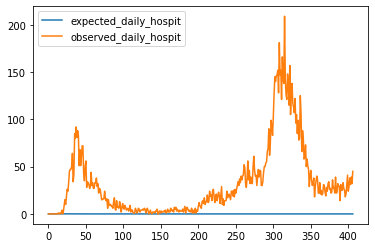

Time Step: 1, Loss: 1008303.75, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 5.056252956390381
 R0:2.2797861099243164, grad: -47.87337112426758, alpha: 0.02339216321706772 grad: -8451.4677734375, sigma: 0.06590133160352707 grad -407.90557861328125


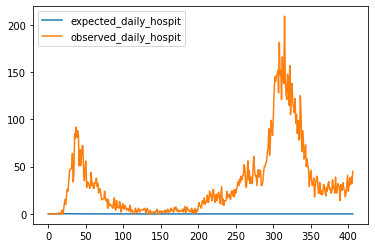

Time Step: 2, Loss: 1008286.625, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 6.577443599700928
 R0:2.279837131500244, grad: -50.976680755615234, alpha: 0.029491497203707695 grad: -6099.33349609375, sigma: 0.06565931439399719 grad 242.01834106445312


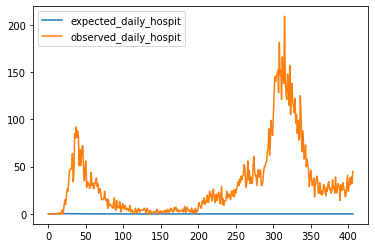

Time Step: 3, Loss: 1008262.375, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 7.978933334350586
 R0:2.279895544052124, grad: -58.43836975097656, alpha: 0.035127654671669006 grad: -5636.1591796875, sigma: 0.06520818173885345 grad 451.130615234375


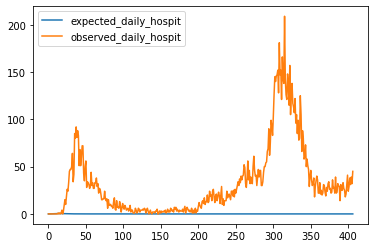

Time Step: 4, Loss: 1008212.4375, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 9.687684059143066
 R0:2.279972791671753, grad: -77.34367370605469, alpha: 0.04125303402543068 grad: -6125.37939453125, sigma: 0.06488043814897537 grad 327.74072265625


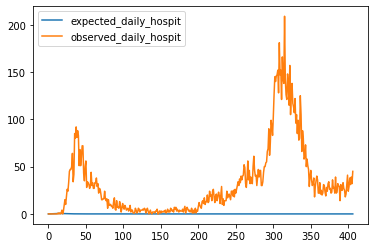

Time Step: 5, Loss: 1008114.3125, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 13.201440811157227
 R0:2.2800893783569336, grad: -116.63644409179688, alpha: 0.04877904802560806 grad: -7526.01416015625, sigma: 0.06542859971523285 grad -548.1634521484375


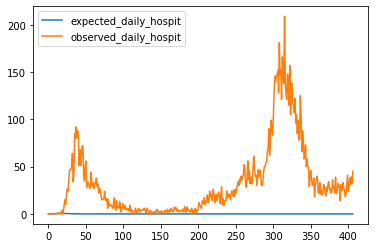

Time Step: 6, Loss: 1008085.375, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 14.730413436889648
 R0:2.280214786529541, grad: -125.39866638183594, alpha: 0.05570638179779053 grad: -6927.3349609375, sigma: 0.06562178581953049 grad -193.18807983398438


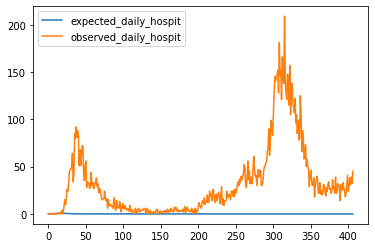

Time Step: 7, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 20.649738311767578
 R0:2.2804059982299805, grad: -191.15504455566406, alpha: 0.06455296277999878 grad: -8846.5849609375, sigma: 0.06793297082185745 grad -2311.18505859375


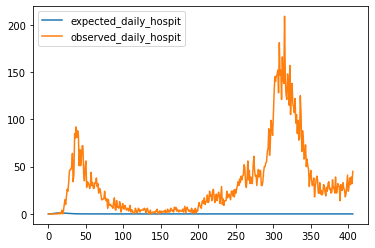

Time Step: 8, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 22.237045288085938
 R0:2.280597686767578, grad: -191.57090759277344, alpha: 0.0723268985748291 grad: -7773.9326171875, sigma: 0.06926174461841583 grad -1328.776123046875


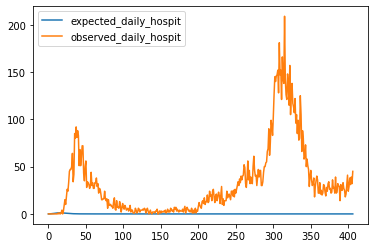

Time Step: 9, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 17.100526809692383
 R0:2.2807066440582275, grad: -108.99898529052734, alpha: 0.07680017501115799 grad: -4473.27587890625, sigma: 0.06754543632268906 grad 1716.309326171875


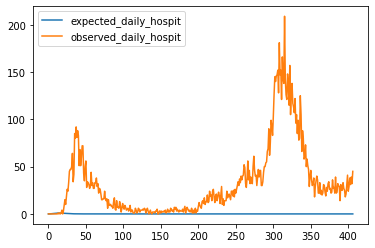

Time Step: 10, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 21.73126220703125
 R0:2.2808754444122314, grad: -168.73324584960938, alpha: 0.08281613141298294 grad: -6015.953125, sigma: 0.06698913872241974 grad 556.298095703125


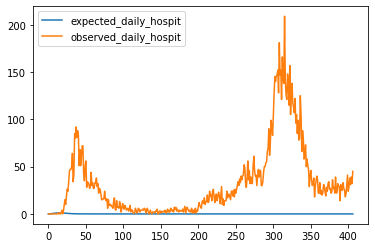

Time Step: 11, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 24.371776580810547
 R0:2.2810685634613037, grad: -193.1184539794922, alpha: 0.08911944180727005 grad: -6303.3134765625, sigma: 0.06677517294883728 grad 213.96502685546875


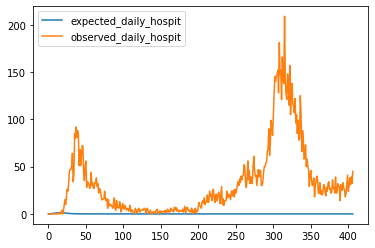

Time Step: 12, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 29.652658462524414
 R0:2.2813239097595215, grad: -255.2978057861328, alpha: 0.09660208225250244 grad: -7482.63916015625, sigma: 0.06843390315771103 grad -1658.7288818359375


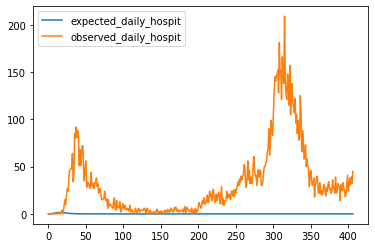

Time Step: 13, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 29.991485595703125
 R0:2.2815630435943604, grad: -239.06251525878906, alpha: 0.10318677872419357 grad: -6584.6953125, sigma: 0.06877338886260986 grad -339.4820251464844


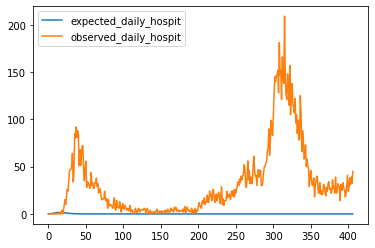

Time Step: 14, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 31.72480010986328
 R0:2.281818151473999, grad: -255.19094848632812, alpha: 0.1097535789012909 grad: -6566.80224609375, sigma: 0.06914428621530533 grad -370.89495849609375


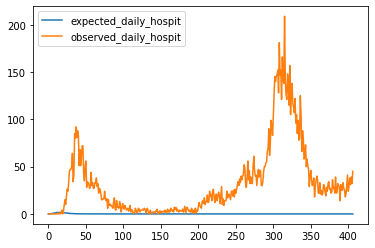

Time Step: 15, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 38.2967643737793
 R0:2.2821292877197266, grad: -311.0211181640625, alpha: 0.11709374189376831 grad: -7340.16015625, sigma: 0.0712328553199768 grad -2088.571044921875


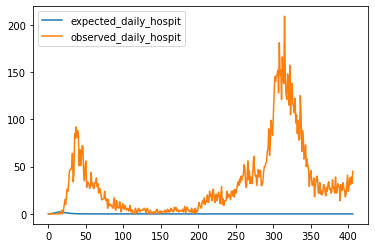

Time Step: 16, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 48.37736511230469
 R0:2.282573699951172, grad: -444.42205810546875, alpha: 0.12656517326831818 grad: -9471.4248046875, sigma: 0.07855334877967834 grad -7320.49072265625


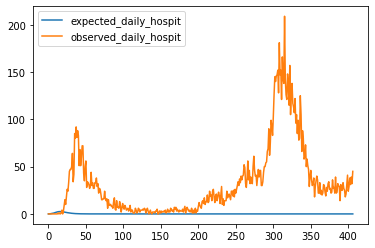

Time Step: 17, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 35.25239181518555
 R0:2.282832622528076, grad: -258.8803405761719, alpha: 0.1321248561143875 grad: -5559.6787109375, sigma: 0.07759534567594528 grad 958.0025024414062


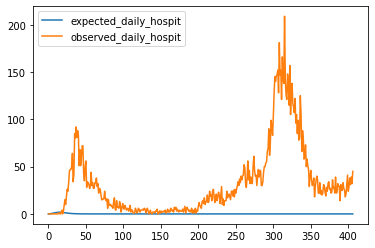

Time Step: 18, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 48.096378326416016
 R0:2.2832655906677246, grad: -432.9804382324219, alpha: 0.1404150277376175 grad: -8290.171875, sigma: 0.08232167363166809 grad -4726.33056640625


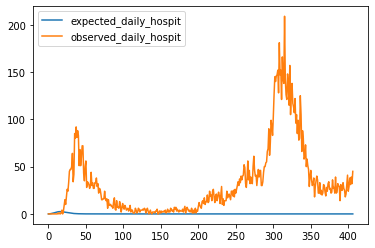

Time Step: 19, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 41.106224060058594
 R0:2.283565044403076, grad: -299.3776550292969, alpha: 0.1461242139339447 grad: -5709.1845703125, sigma: 0.08167481422424316 grad 646.86279296875


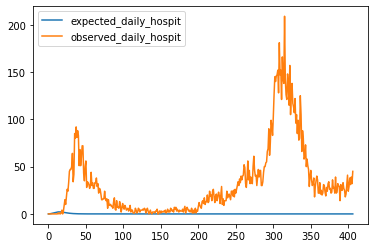

Time Step: 20, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 43.525901794433594
 R0:2.283900499343872, grad: -335.4814758300781, alpha: 0.15219378471374512 grad: -6069.56494140625, sigma: 0.08164460211992264 grad 30.211318969726562


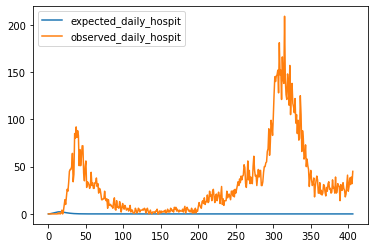

Time Step: 21, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 52.37018585205078
 R0:2.2843267917633057, grad: -426.3006591796875, alpha: 0.15935353934764862 grad: -7159.75537109375, sigma: 0.08427215367555618 grad -2627.552978515625


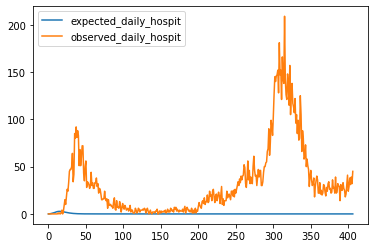

Time Step: 22, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 42.227237701416016
 R0:2.2846179008483887, grad: -291.0545349121094, alpha: 0.1643521934747696 grad: -4998.65087890625, sigma: 0.08241596072912216 grad 1856.1944580078125


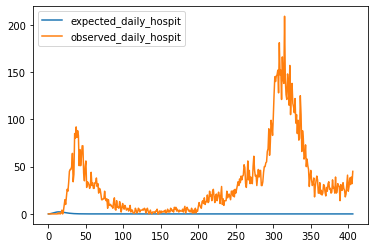

Time Step: 23, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 47.720848083496094
 R0:2.284968376159668, grad: -350.5600280761719, alpha: 0.17001165449619293 grad: -5659.46044921875, sigma: 0.08179229497909546 grad 623.6655883789062


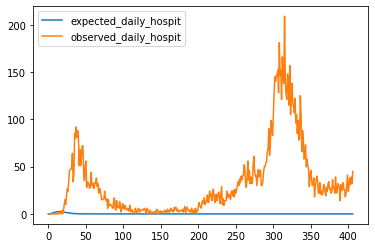

Time Step: 24, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 44.41082763671875
 R0:2.285278081893921, grad: -309.82000732421875, alpha: 0.17498387396335602 grad: -4972.2236328125, sigma: 0.07979517430067062 grad 1997.117919921875


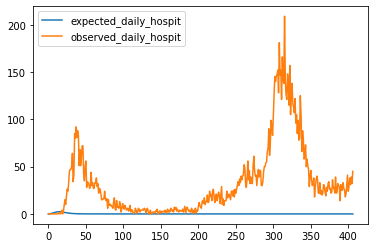

Time Step: 25, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 46.789520263671875
 R0:2.285613536834717, grad: -335.345703125, alpha: 0.18015658855438232 grad: -5172.70703125, sigma: 0.07809610664844513 grad 1699.07080078125


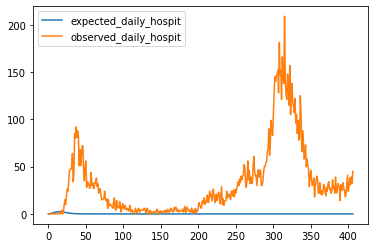

KeyboardInterrupt: ignored

In [9]:
learning_rate = 1e-6

for t in range (100):
  # forward pass - calculate expected_daily_hospit
  expected_daily_hospit = forward_pass()

  loss = (observed_daily_hospit - expected_daily_hospit).pow(2).sum()
    # for i in 1:num_obs
    #   ℓ += logpdf( NegativeBinomial2(expected_daily_hospit[i], ϕ), observed_hospit[i])
  loss -= truncnorm.logpdf(x=R0.detach().numpy() ,a=2, b=5, loc=0, scale=0.8)
  loss += truncnorm.logpdf(x=alpha.detach().numpy(),a=0 , b=5/100, loc=0, scale=1)
  loss += truncnorm.logpdf(x=sigma.detach().numpy(),a=0 , b=0.15, loc=0, scale=1)
  loss.backward()

  print(f'Time Step: {t}, Loss: {loss}, Observed_daily_hospit: {torch.sum(observed_daily_hospit)}, Expected_daily_hospit: {torch.sum(expected_daily_hospit)}')
  

  with torch.no_grad():
    #tau_t -= learning_rate * tau_t.grad
    #phi -= learning_rate * phi.grad
    R0 -= learning_rate * R0.grad
    alpha -= learning_rate * alpha.grad
    sigma -= learning_rate * sigma.grad
    print(f' R0:{R0}, grad: {R0.grad}, alpha: {alpha} grad: {alpha.grad}, sigma: {sigma} grad {sigma.grad}' )

    #tau_t.grad = None
    #phi.grad = None
    R0.grad = None
    alpha.grad = None
    sigma.grad = None
  
  
  plt.plot(expected_daily_hospit.detach().numpy(), label='expected_daily_hospit')
  plt.plot(observed_daily_hospit.detach().numpy(), label='observed_daily_hospit')
  plt.legend()
  plt.show()

compare observed hospitalizations to model results

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(expected_daily_hospit.detach().numpy(), label='expected_daily_hospit')
plt.plot(observed_daily_hospit.detach().numpy(), label='observed_daily_hospit')
plt.legend()
plt.show()